In [1]:
# import libraries
import numpy as np
import pandas as pd
from numpy import genfromtxt
import math
from scipy import optimize
import matplotlib.pyplot as plt
import csv
import sqlite3
import os
import urllib.request

In [2]:
# Function for the SIR model with two levels of alpha and beta -- O(n) speed
#
# INPUTS
# 
# S0 - initial number of susceptible people
# I0 - initial number of infected people
# R0 - initial number of recovered people (including those who died)
# alpha1 - initial recovery rate
# alpha2 - later recovery rate
# beta1 - initial contact rate
# beta2 - later recovery rate
# n1 - time when alpha transitions
# n2 - time when beta transitions
# n - amount of days to simulate
#
# OUTPUTS
#
# SIR - a 3-by-(n+1) matrix storing the simulated paths for S(t), I(t), and R(t) for t = 0, 1, 2, ..., n

def sir22(S0,I0,R0,alpha1,alpha2,beta1,beta2,n1,n2,n):
    SIR = np.zeros((3,n+1))
    
    # Fill in initial data
    SIR[:,0] = np.array([S0, I0, R0])
    
    alpha = alpha1
    beta = beta1
    
    for i in range(n):
        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i], beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i], alpha*SIR[1,i]])
        
        if i is n1:
            alpha = alpha2
        
        if i is n2:
            beta = beta2
    
    return SIR

In [3]:
# Function for the standard SIR model -- O(n) speed
#
# INPUTS
# 
# S0 - initial number of susceptible people
# I0 - initial number of infected people
# R0 - initial number of recovered people (including those who died)
# alpha - recovery rate
# beta - contact rate
# n - amount of days to simulate
#
# OUTPUTS
#
# SIR - a 3-by-(n+1) matrix storing the simulated paths for S(t), I(t), and R(t) for t = 0, 1, 2, ..., n

def sir11(S0,I0,R0,alpha,beta,n):
    SIR = np.zeros((3,n+1))
    
    # Fill in initial data
    SIR[:,0] = np.array([S0, I0, R0])
    
    for i in range(n):
        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i], beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i], alpha*SIR[1,i]])
    
    return SIR

In [4]:
# Function to compute the error between predicted data and real data
#
# INPUTS
#
# data - 3-by-(n+1) matrix of real data for S(t), I(t), R(t) at times t = 0, 1, ..., l
# precition - 3-by-(n+1) matrix of simulated data for S(t), I(t), and R(t) for t = 0, 1, ..., l
#
# OUTPUTS
#
# error - the sum of squared differences between real and simulated data (using root of sum of squared L2 norms)

def findError(data,prediction):
    return math.sqrt(np.sum((data - prediction)**2))

In [5]:
# Read CSV file into dataframe and clean it
def cleanCSV(filename):
    # Read the csv file into a Pandas dataframe
    df = pd.read_csv(filename)

    # Replace slashes in header with _
    df.columns =[column.replace("/", "_") for column in df.columns]
    
    return df

In [6]:
def downloadDataIntoCleanRows():
    # Download and clean confirmed cases by country/date
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    filename = 'time_series_covid19_confirmed_global.csv'
    urllib.request.urlretrieve(url, filename)
    confirmed = cleanCSV(filename)

    # Download and clean recovered cases by country/date
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    filename = 'time_series_covid19_recovered_global.csv'
    urllib.request.urlretrieve(url, filename)
    recovered = cleanCSV(filename)

    # Download and clean deaths by country/date
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    filename = 'time_series_covid19_deaths_global.csv'
    urllib.request.urlretrieve(url, filename)
    deaths = cleanCSV(filename)
    
    return confirmed, recovered, deaths

In [12]:
# Get data for queried country
def queryForCountry(confirmed,recovered,deaths,country):
    popData = pd.read_csv('WorldDevelopmentIndicatorsApr92020.csv')
    popData.columns =[column.replace(" ", "_") for column in popData.columns]
    population = popData.query("Country_Name == @country").to_numpy()[0,1]
    
    # Query for country data
    confirmed = confirmed.query("Country_Region == @country")
    recovered = recovered.query("Country_Region == @country")
    dead = deaths.query("Country_Region == @country")
    
    # Prep data and drop columns when there are no cases
    confirmed = confirmed.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)
    confirmed = confirmed.to_numpy()[0]
    
    # Index of first case plus 9 days
    firstCase = np.nonzero(confirmed)[0][0] + 9
    print(firstCase)
    
    # Cut dates before the first infected case
    confirmed = confirmed[firstCase:]

    recovered = recovered.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)
    recovered = recovered.to_numpy()[0]
    recovered = recovered[firstCase:]

    dead = dead.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)
    dead = dead.to_numpy()[0]
    dead = dead[firstCase:]

    # Turn the data into S I R data
    R = recovered + dead
    I = confirmed - R
    S = population - I - R

    # Create data array
    data = np.vstack((S, I, R))

    # Convert data array to float
    data = np.array(list(data[:, :]), dtype=np.float64)

    # Find number of days of data
    lastData = np.size(data,1) - 1
    
    return data, lastData, firstCase

In [13]:
# Find values for the parameters minimizing the error

confirmed, recovered, deaths = downloadDataIntoCleanRows()

data, lastData, firstCase = queryForCountry(confirmed,recovered,deaths,'Jordan')

# Read the initial data from the first column of data
S0 = data[0,0]
I0 = data[1,0]
R0 = data[2,0]

# Create a function of the parameters that runs the simulator and measures the error from the real data
f = lambda x: findError(sir22(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,18,10,lastData),data)

50


In [14]:
# Optimize the parameters (via gradient descent)
result = optimize.minimize(f,[0.1, 0.1, 0.2, 0.2],bounds = ((0,1),(0,1),(0,1),(0,1)))

# Let x be the parameters found above
x = result.x

# Return details about the optimization
result

      fun: 176.88260915505188
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0604814 , -0.0062812 ,  0.10050485,  0.19325057])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 355
      nit: 37
   status: 0
  success: True
        x: array([0.0070932 , 0.07774867, 0.61170107, 0.0476496 ])

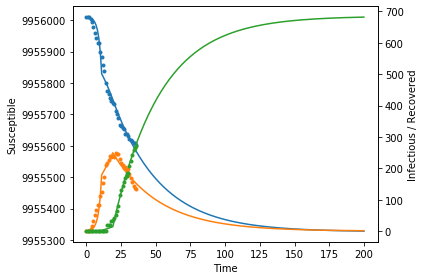

In [11]:
# Simulate SIR again with optimal parameters and plot it with the real data
SIR = sir22(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,18,10,200)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Susceptible')
ax1.plot(SIR[0,:],color='tab:blue')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Infectious / Recovered')  # we already handled the x-label with ax1
ax2.plot(SIR[1,:],color='tab:orange')
ax2.plot(SIR[2,:],color='tab:green')
ax2.tick_params(axis='y')

ax1.plot(data[0,:],'.',color='tab:blue')
ax2.plot(data[1,:],'.',color='tab:orange')
ax2.plot(data[2,:],'.',color='tab:green')

ax1.ticklabel_format(useOffset=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

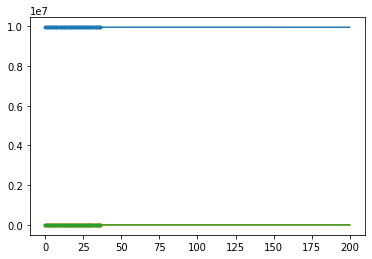

In [12]:
plt.plot(SIR[0,:])
plt.plot(SIR[1,:])
plt.plot(SIR[2,:])

plt.gca().set_prop_cycle(None)

plt.plot(data[0,:],'.')
plt.plot(data[1,:],'.')
plt.plot(data[2,:],'.')

In [10]:
bestError = [0,0,0,0,0,0,1000000]

# This code optimizes the parameters but also times when alpha and beta change
# Note that it is brute force in the times, so this runs SLOWLY

for n1 in range(int(lastData/3),lastData):
    
    mError = bestError[-1]
    
    print(n1)
    for n2 in range(int(lastData/5),lastData):
        # optimize the alpha and beta parameters for given n1 and n2
        f = lambda x: findError(sir22(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,n1,n2,lastData),data)
        result = optimize.minimize(f,[0.1, 0.1, 0.2, 0.2], bounds = ((0,1),(0,1),(0,1),(0,1)))
        
        # If we find a lower error than we found previously, record the parameters and error
        if result.fun < bestError[-1]:
            x = result.x
            bestError = [x[0], x[1], x[2], x[3], n1, n2, result.fun]
    
    if bestError[-1] == mError:
        break
        
    # Display the best parameters and error we found so far
    print(bestError)

12
[0.0, 0.055440692479481406, 0.5627167455394336, 0.04435742399958146, 12, 11, 252.8106338745577]
13
[0.0, 0.05869163949938361, 0.5604921626134632, 0.04483960083109135, 13, 11, 234.61793279662672]
14
[0.0, 0.06222341857779198, 0.5584069535192409, 0.04517744453643131, 14, 11, 217.7068142931486]
15
[0.0, 0.06610434446365042, 0.5564864533640101, 0.04536670027532379, 15, 11, 202.18593504415728]
16
[0.0, 0.07167614546875158, 0.6055818492631427, 0.04843963043508369, 16, 10, 189.79811991833478]
17
[0.00023039803847530046, 0.07746963019478668, 0.6672172453343894, 0.0508557233767315, 17, 9, 188.11772956283]
18
[0.007093195936275441, 0.07774867076730349, 0.6117010657109857, 0.04764959634242392, 18, 10, 176.88260915505188]
19
[0.013580298811566607, 0.07784351532388996, 0.5672124201508237, 0.04419987472828944, 19, 11, 173.93406814647855]
20
[0.017243897256569815, 0.08040351840049202, 0.5710721885272736, 0.04376283570061301, 20, 11, 172.7672953609359]
21


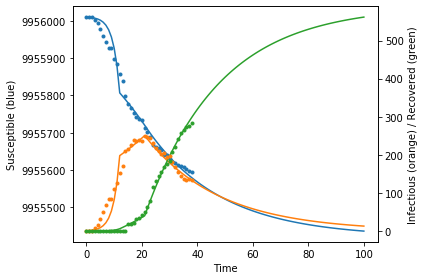

In [11]:
# plot with the optimal parameters
SIR = sir22(S0,I0,R0,bestError[0],bestError[1],bestError[2]/S0,bestError[3]/S0,bestError[4],bestError[5],100)

#fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Susceptible (blue)')
ax1.plot(SIR[0,:],color='tab:blue')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Infectious (orange) / Recovered (green)')  # we already handled the x-label with ax1
ax2.plot(SIR[1,:],color='tab:orange')
ax2.plot(SIR[2,:],color='tab:green')
ax2.tick_params(axis='y')

ax1.plot(data[0,:],'.',color='tab:blue')
ax2.plot(data[1,:],'.',color='tab:orange')
ax2.plot(data[2,:],'.',color='tab:green')

#ax1.set_ylim([9719000,9720000])
ax1.ticklabel_format(useOffset=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#plt.plot(SIR[0,:])
#plt.plot(SIR[1,:])
#plt.plot(SIR[2,:])

#plt.gca().set_prop_cycle(None)

#plt.plot(data[0,:],'.')
#plt.plot(data[1,:],'.')
#plt.plot(data[2,:],'.')

In [15]:
## FIND BEST PARAMETERS FOR COUNTRIES IN THE LIST

# Download data and put into rows
confirmed, recovered, deaths = downloadDataIntoCleanRows()

countries = ['Algeria', 'Bahrain', 'Cyprus', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Lebanon', 'Morocco', 'Oman', 'Qatar', 'Saudi Arabia', 'Tunisia', 'Turkey', 'United Arab Emirates', 'West Bank and Gaza']

#countries = ['Algeria', 'Bahrain', 'Cyprus']

errorStore = []

for country in countries:
    print(country)
    
    data, lastData, firstCase = queryForCountry(confirmed,recovered,deaths,country)

    # Read the initial data from the first column of data
    S0 = data[0,0]
    I0 = data[1,0]
    R0 = data[2,0]
    
    # bestError = [country,firstCase, alpha1, alpha2, beta1, beta2, n1, n2, error]
    bestError = ['a',0,0,0,0,0,0,0,1000000]

    # This code optimizes the parameters but also times when alpha and beta change
    # Note that it is brute force in the times, so this runs SLOWLY

    for n1 in range(int(lastData/4),lastData):

        mError = bestError[-1]

        print(n1)
        for n2 in range(int(lastData/5),lastData):
            # optimize the alpha and beta parameters for given n1 and n2
            f = lambda x: findError(sir22(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,n1,n2,lastData),data)
            result = optimize.minimize(f,[0.1, 0.1, 0.2, 0.2], bounds = ((0,1),(0,1),(0,1),(0,1)))

            # If we find a lower error than we found previously, record the parameters and error
            if result.fun < bestError[-1]:
                x = result.x
                bestError = [firstCase, x[0], x[1], x[2], x[3], n1, n2, result.fun]

        if bestError[-1] == mError:
            break
            
    errorStore.append(bestError)

Algeria
10
11
Bahrain
11
12
Cyprus
7
8
9
10
11
12
13
14
15
16
17
Egypt
13
14
Iran
12
13
Iraq
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Israel
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
Jordan
9
10
11
12
13
14
15
16
17
18
19
20
21
Lebanon
11
12
Morocco
9
10
Oman
11
12
Qatar
9
10
11
12
13
14
Saudi Arabia
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Tunisia
8
9
10
11
Turkey
7
8
9
United Arab Emirates
17
18
West Bank and Gaza
8
9


In [61]:
df = pd.DataFrame(data=errorStore,index=countries,columns=['day of first case+10', 'initial alpha', 'final alpha', 'initial beta', 'final beta', 'alpha switchover', 'beta switchover', 'error'])

In [62]:
df

,day of first case+10,initial alpha,final alpha,initial beta,final beta,alpha switchover,beta switchover,error
Algeria,43,0.085265,0.052778,0.224936,0.063205,10,29,615.619175
Bahrain,42,0.015826,0.082142,0.117881,0.240246,10,35,467.548237
Cyprus,56,0.023119,0.007770,0.154551,0.054854,12,15,86.516515
Egypt,32,0.012215,0.039573,0.266901,0.118160,13,24,454.011361
Iran,37,0.000000,0.081733,0.209753,0.072311,12,30,42866.080652
Iraq,42,0.047521,0.076929,0.147465,0.048426,26,33,236.985511
Israel,39,0.000000,0.017304,0.240651,0.047450,25,30,2984.417829
Jordan,50,0.000000,0.047442,0.525120,0.040388,9,12,259.305280
Lebanon,39,0.000000,0.010667,0.161726,0.030064,11,24,124.749335
Morocco,49,0.000000,0.021247,0.318506,0.095068,9,17,305.400174
